# Introduction

**In this kernel i will try to share my understanding and findings of cross lingual models.Feel free to correct me if I made any mistakes in this kernel.**



**ChangeLog**
* version 1 : training xlm roberta base for 1 epoch including validation english data in training set
* version 2 :  training for 4 epoch (poor lb : close to 0.89)
* version 3 : gamma=2.0 for focal loss, reducing train non toxic comment samples,removing translated validation data from train set,patience = 1 and epoch = 6 (bug)
* version 4 : same as version 3 but trying to fix the  problem for 3 epoch(i was not monitoring val auc correctly in version 3) 
* version 5 : error
* version 6 : patience = 2, extra 2 epochs using validation set
* version 7 : using translated validation data + focal_loss(gamma=1.5,alpha = .25)
* version 8 : More text cleaning(everything else is left same as version 7 so that we can compare version 7 with version 8's result for additional text cleaning) --> clean_text,replace_typical_misspell,handle_contractions,fix_quote
* version 9 : as you can see now that in version 7 lb = 0.8987 and in version 8 we got lb 0.9151 where the only difference in version 9 was to add extra text cleaning techniques :) now in version 9 i will move to xlmr-large model  with maxlen = 192, BATCH_SIZE = 16 * strategy.num_replicas_in_sync and keeping everything else as it was before
* version 10 : as we see version 9 model diverged and it seems like  loss=focal_loss(gamma=1.5,alpha = .25) worked just fine for xlmr base but not with large so will just try binary_crossentropy instead just to make sure whether or not my assumption is correct (leaving everything else as it is) saving model based on maximum validation accuracyand using EarlyStopping, ModelCheckpoint, LearningRateScheduler,training for 4 epochs 
* version 11 : trying to solve error of version 10
* version 12 : trying to solve bugs of version 11 
* version 13 : adding translated spanish data in training set 
* version 14 : oversampling validation english data, reducing spanish non english sample a bit for training for 5 epochs within 3 hours tpu limit (failed : couldn't finish commit within 3 hours  tpu limit)
* version 15 : trying for 4 epoch and oversampling positive samples of translated validation set
* version 16 : more data for training(958870 total) and using 2 epochs because it will take time [Note --> one thing i found in this competition is : large subset of trainset helps the learning algorithm perform better here instead of choosing small subset for long training] 
* version 17 : in version 16 you can see i got NotImplementedError after first epoch and i am unable to save best checkpoint,in previous versions i also tried  monitor='val_acc' and monitor='val_accuracy' but none of them saving best checkpoint for me,where am i making mistakes? in version 17 i will try to get rid of the error and will train again(if you know why i am unable to save best checkpoint please help me in the comment box) thanks in advance

**Imports**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F



import warnings
warnings.filterwarnings("ignore")

import os
import gc
import re
import folium
#import textstat
from scipy import stats
from colorama import Fore, Back, Style, init

import math
import numpy as np
import scipy as sp
import pandas as pd

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import transformers
import tensorflow as tf

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets
from tensorflow.keras.optimizers import Adam
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from sklearn import metrics
from sklearn.utils import shuffle
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer,\
                                            CountVectorizer,\
                                            HashingVectorizer

from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

import nltk
from textblob import TextBlob

from nltk.corpus import wordnet
from nltk.corpus import stopwords
#from googletrans import Translator
from nltk import WordNetLemmatizer
#from polyglot.detect import Detector
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer

stopword=set(STOPWORDS)

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

np.random.seed(0)




Using TensorFlow backend.


# Part 1 : Understanding cross lingual models

the paper titled [**Cross-lingual Language Model Pretraining**](https://arxiv.org/abs/1901.07291) by Facebook AI, named XLM, presents an improved version of BERT to achieve state-of-the-art results in both classification and translation tasks.XLM uses a known pre-processing technique (BPE) and a dual-language training mechanism with BERT in order to learn relations between words in different languages. The model outperforms other models in a cross-lingual classification task (sentence entailment in 15 languages) and significantly improves machine translation when a pre-trained model is used for initialization of the translation model.

# XLM is based on several key concepts:

**Transformers** : The Transformer architecture is at the core of almost all the recent major developments in NLP.It introduced an attention mechanism that processes the entire text input simultaneously to learn contextual relations between words (or sub-words). A Transformer includes two parts — an encoder that reads the text input and generates a lateral representation of it (e.g. a vector for each word), and a decoder that produces the translated text from that representation.

**A High-Level Look**

Let’s begin by looking at the model as a single black box. In a machine translation application, it would take a sentence in one language, and output its translation in another.

![](https://jalammar.github.io/images/t/the_transformer_3.png)

Popping open that Optimus Prime goodness, we see an encoding component, a decoding component, and connections between them.

![](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

The encoding component is a stack of encoders (the paper stacks six of them on top of each other – there’s nothing magical about the number six, one can definitely experiment with other arrangements). The decoding component is a stack of decoders of the same number.

![](https://jalammar.github.io/images/t/The_transformer_encoder_decoder_stack.png)

The encoders are all identical in structure (yet they do not share weights). Each one is broken down into two sub-layers:

![](https://jalammar.github.io/images/t/Transformer_encoder.png)

The encoder’s inputs first flow through a self-attention layer – a layer that helps the encoder look at other words in the input sentence as it encodes a specific word. We’ll look closer at self-attention later in the post.

The outputs of the self-attention layer are fed to a feed-forward neural network. The exact same feed-forward network is independently applied to each position.

The decoder has both those layers, but between them is an attention layer that helps the decoder focus on relevant parts of the input sentence (similar what attention does in seq2seq models).

![](https://jalammar.github.io/images/t/Transformer_decoder.png)

This Transformer architecture outperformed both RNNs and CNNs (convolutional neural networks). The computational resources required to train models were reduced as well. A win-win for everyone in NLP. Check out the below comparison:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/transformercomparison.png)

The below animation wonderfully illustrates how Transformer works on a machine translation task:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/03/transform20fps.gif)

The vanilla Transformer has only limited context of each word, i.e. only the predecessors of each word, in 2018 updated BERT used the Transformer’s encoder to learn a language model by masking (dropping) some of the words and then trying to predict them, allowing it to uses the entire context, i.e. words to the left and right of a masked word.

**How XLM works?**

The paper [**Cross-lingual Language Model Pretraining**](https://arxiv.org/abs/1901.07291) presents two innovative ideas — a new training technique of BERT for multilingual classification tasks and the use of BERT as initialization of machine translation models.

These are the language the XLM model supports: en-es-fr-de-zh-ru-pt-it-ar-ja-id-tr-nl-pl-simple-fa-vi-sv-ko-he-ro-no-hi-uk-cs-fi-hu-th-da-ca-el-bg-sr-ms-bn-hr-sl-zh_yue-az-sk-eo-ta-sh-lt-et-ml-la-bs-sq-arz-af-ka-mr-eu-tl-ang-gl-nn-ur-kk-be-hy-te-lv-mk-zh_classical-als-is-wuu-my-sco-mn-ceb-ast-cy-kn-br-an-gu-bar-uz-lb-ne-si-war-jv-ga-zh_min_nan-oc-ku-sw-nds-ckb-ia-yi-fy-scn-gan-tt-am.


The process of cross-lingual sentiment classification. We assume that the opinion units have already been determined. The English train set is used to train a classifier. The Spanish test set is mapped accordingly and the classifier is tested on this cross-lingual test set.check the below pictures : 
![](https://www.researchgate.net/profile/Jeremy_Barnes5/publication/309312650/figure/fig1/AS:669424235323406@1536614583578/The-process-of-cross-lingual-sentiment-classification-We-assume-that-the-opinion-units_W640.jpg)
here L1 means language 1 and L2 means language 2
![](https://slideplayer.com/slide/12311059/73/images/13/Cross-lingual+Document+Classification.jpg)

* First, instead of using word or characters as the input of the model, it uses Byte-Pair Encoding (BPE) that splits the input into the most common sub-words across all languages, thereby increasing the shared vocabulary between languages.

* Second, it upgrades the BERT architecture in two manners:

     1.  Each training sample consists of the same text in two languages, whereas in BERT each sample is built from a single language. As in BERT, the goal of the model is to predict the masked tokens, however, with the new architecture, the model can use the context from one language to predict tokens in the other, as different words are masked words in each language (they are chosen randomly).   
     
     2. The model also receives the language ID and the order of the tokens in each language, i.e. the Positional Encoding, separately. The new metadata helps the model learn the relationship between related tokens in different languages.
     

**The upgraded BERT is denoted as Translation Language Modeling (TLM) while the “vanilla” BERT with BPE inputs is denoted as Masked Language Modeling (MLM).**

# Training a Masked Language Model(MLM) for BERT

let's say the problem statement is : **Given an input sequence, we will randomly mask some words. The model then should predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence.**

**For quick demonstration purpose i will use code from analyticsvidhya's article [Introduction to PyTorch-Transformers: An Incredible Library for State-of-the-Art NLP (with Python code)](https://www.analyticsvidhya.com/blog/2019/07/pytorch-transformers-nlp-python/)**

First, let’s prepare a tokenized input from a text string using BertTokenizer:

In [2]:
import torch
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

MODEL = 'jplu/tf-xlm-roberta-base'
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)

100%|██████████| 231508/231508 [00:00<00:00, 1926372.31B/s]


This is how our text looks like after tokenization:

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/07/Screenshot-from-2019-07-18-15-18-42.png)

The next step would be to convert this into a sequence of integers and create PyTorch tensors of them so that we can use them directly for computation:

In [3]:
# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

Notice that we have set [MASK] at the 8th index in the sentence which is the word ‘Hensen’. This is what our model will try to predict.

Now that our data is rightly pre-processed for BERT, we will create a Masked Language Model. Let’s now use BertForMaskedLM to predict a masked token:

In [4]:
# Load pre-trained model (weights)
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device)
model.to(device)

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    predictions = outputs[0]

# confirm we were able to predict 'henson'
predicted_index = torch.argmax(predictions[0, masked_index]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
assert predicted_token == 'henson'
print('Predicted token is:',predicted_token)

100%|██████████| 440473133/440473133 [00:10<00:00, 41148068.10B/s]


cpu
Predicted token is: henson


In [5]:
#model

This was a small demo of training a Masked Language Model on a single input sequence.

The complete XLM model was trained by training both MLM and TLM and alternating between them.

![](https://miro.medium.com/max/1400/0*lBYVNRe1esIXn1qE.png)

To assess the contribution of the model, the paper presents its results on sentence entailment task (classify relationship between sentences) using XNLI dataset that includes sentences in 15 languages. The model significantly outperforms other prominent models

# Unsupervised Cross-lingual Representation Learning at Scale

Abstract : 
This paper [Unsupervised Cross-lingual Representation Learning at Scale](https://arxiv.org/abs/1911.02116) shows that pretraining multilingual language models at scale leads to significant performance gains for a wide range of cross-lingual transfer tasks. We train a Transformer-based masked language model on one hundred languages, using more than two terabytes of filtered CommonCrawl data. Our model, dubbed XLM-R, significantly outperforms multilingual BERT (mBERT) on a variety of cross-lingual benchmarks, including +13.8% average accuracy on XNLI, +12.3% average F1 score on MLQA, and +2.1% average F1 score on NER. XLM-R performs particularly well on low-resource languages, improving 11.8% in XNLI accuracy for Swahili and 9.2% for Urdu over the previous XLM model. We also present a detailed empirical evaluation of the key factors that are required to achieve these gains, including the trade-offs between (1) positive transfer and capacity dilution and (2) the performance of high and low resource languages at scale. Finally, we show, for the first time, the possibility of multilingual modeling without sacrificing per-language performance; XLM-Ris very competitive with strong monolingual models on the GLUE and XNLI benchmarks. We will make XLM-R code, data, and models publicly available.

# Part 2 : Implementation using TPU Multiprocessing

Even though i am a pytorch lover but not sure if the video below is true for 2020 also or not....!!!!

In [6]:
from IPython.core.display import HTML


HTML('''<iframe width="560" height="315" src="https://www.youtube.com/embed/744f60NyAgc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>''')

**implementation  is adapted from @tarunpaparaju's kernel  [Jigsaw Multilingual Toxicity : EDA + Models](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models)**

XLM-R handles the following 100 languages: Afrikaans, Albanian, Amharic, Arabic, Armenian, Assamese, Azerbaijani, Basque, Belarusian, Bengali, Bengali Romanized, Bosnian, Breton, Bulgarian, Burmese, Burmese, Catalan, Chinese (Simplified), Chinese (Traditional), Croatian, Czech, Danish, Dutch, English, Esperanto, Estonian, Filipino, Finnish, French, Galician, Georgian, German, Greek, Gujarati, Hausa, Hebrew, Hindi, Hindi Romanized, Hungarian, Icelandic, Indonesian, Irish, Italian, Japanese, Javanese, Kannada, Kazakh, Khmer, Korean, Kurdish (Kurmanji), Kyrgyz, Lao, Latin, Latvian, Lithuanian, Macedonian, Malagasy, Malay, Malayalam, Marathi, Mongolian, Nepali, Norwegian, Oriya, Oromo, Pashto, Persian, Polish, Portuguese, Punjabi, Romanian, Russian, Sanskri, Scottish, Gaelic, Serbian, Sindhi, Sinhala, Slovak, Slovenian, Somali, Spanish, Sundanese, Swahili, Swedish, Tamil, Tamil Romanized, Telugu, Telugu Romanized, Thai, Turkish, Ukrainian, Urdu, Urdu Romanized, Uyghur, Uzbek, Vietnamese, Welsh, Western, Frisian, Xhosa, Yiddish.

In [7]:
import pandas as pd

In [8]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

train3 = pd.read_csv('../input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-es-cleaned.csv')

train4 = pd.read_csv('../input/jigsaw-train-multilingual-coments-google-api/jigsaw-toxic-comment-train-google-es-cleaned.csv')

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

toxic = len(train2[['comment_text', 'toxic']].query('toxic==1'))
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    
    train3[['comment_text', 'toxic']].query('toxic==0'),
    train3[['comment_text', 'toxic']].query('toxic==1'),
    
    train4[['comment_text', 'toxic']].query('toxic==0'),
    train4[['comment_text', 'toxic']].query('toxic==1'),
    
    
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=(toxic+(toxic//3)), random_state=101)
])

test_data = test
train_data = train

maxlen = 192

In [9]:
valid.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


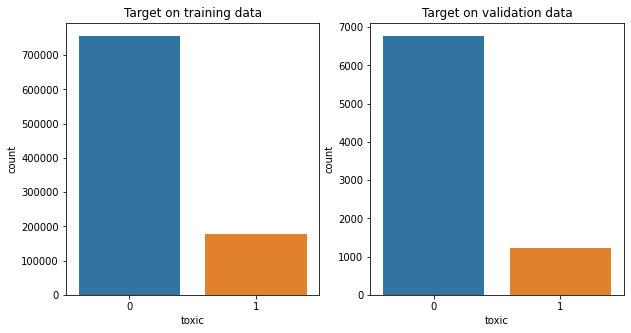

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(train_data['toxic'])
plt.title('Target on training data')

plt.subplot(1, 2, 2)
sns.countplot(valid['toxic'])
plt.title('Target on validation data')

plt.show()

In [11]:
df_valid_en = pd.read_csv('../input/val-en-df/validation_en.csv')



df_valid_en = df_valid_en.drop(columns=['id', 'comment_text','lang'])
df_valid_en = df_valid_en.rename(columns={"comment_text_en": "comment_text"})
columns_titles = ["comment_text","toxic"]
df_valid_en=df_valid_en.reindex(columns=columns_titles)

'''df2 = df_valid_en[df_valid_en.toxic == 1]
df_valid_en = pd.concat([df_valid_en,df2])
df_valid_en = pd.concat([df_valid_en,df2])  #doubling twice
'''

print(df_valid_en.head(3))

train_data = pd.concat([train_data , df_valid_en], axis=0).reset_index(drop=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)

print(len(train2[['comment_text', 'toxic']].query('toxic==1')))
print(len(train_data))
train_data.head()



                                        comment_text  toxic
0  This user does not even rank heretic. Therefor...      0
1  The text of this item seems to be plagiarized ...      0
2  OK. I'm just stating my past. All past time wa...      1
112226
940165


,comment_text,toxic
0,"It already has boots, ISIS members posing as b...",0
1,"""\n\n Capitain """"certain"""" of his child being ...",0
2,I will beat you \n\nYOU FAILED AGAIN TO BLOCK ...,1
3,""" \n\n Please do not vandalize pages, as you ...",0
4,So many of you folks are so shallow on this is...,1


**Clean the text (remove usernames and links)**

In [12]:
val = valid
train = train_data

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

val["comment_text"] = clean(val["comment_text"])
test_data["content"] = clean(test_data["content"])
train["comment_text"] = clean(train["comment_text"])

# More Text Cleaning

**applying text cleaning techniques like clean_text,replace_typical_misspell,handle_contractions,fix_quote 
on train,test and validation set**

In [13]:
# https://www.kaggle.com/chenshengabc/from-quest-encoding-ensemble-a-little-bit-differen

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x).replace("\n","")
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [14]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
#         df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower())) 
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
        df[col] = df[col].apply(lambda x: handle_contractions(x))  
        df[col] = df[col].apply(lambda x: fix_quote(x))   
    
    return df



In [15]:
%%time
input_columns = [
    'comment_text'   
]

'''applying text cleaning techniques like clean_text,replace_typical_misspell,handle_contractions,fix_quote 
on train,test and validation set'''

train = clean_data(train, input_columns ) 
val = clean_data(val, input_columns )


CPU times: user 14min 16s, sys: 4.41 s, total: 14min 20s
Wall time: 14min 20s


In [16]:
%%time
input_columns = [
    'content'   
]
test_data = clean_data(test_data, input_columns )

del tokenizer

CPU times: user 57.2 s, sys: 16.8 ms, total: 57.2 s
Wall time: 57.2 s


**we can see from above 2 cells that text cleaning for train,validation and test set takes 8+ minutes that means we are losing some of our vital times for training  on tpu which is 3 hours(max). so it would be a good idea if we create another kernel and save above 2 cells newly updated train,val and test_data as kernels output then using those files we can quickly import our new train,test and validation data here,which will save time for training model on TPU **

**Roc-Auc Evaluation metric**

In [17]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

# Tokenize(encode) comments

In [18]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

**Load bert tokenizer**

In [19]:
MODEL = 'jplu/tf-xlm-roberta-large'
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

save_path = '/kaggle/working/xlmr_large/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)



('/kaggle/working/xlmr_large/sentencepiece.bpe.model',
 '/kaggle/working/xlmr_large/special_tokens_map.json',
 '/kaggle/working/xlmr_large/added_tokens.json')

**Encode comments**

In [20]:
%%time
x_train = regular_encode(train.comment_text.astype(str), 
                      tokenizer, maxlen=maxlen)
x_valid = regular_encode(val.comment_text.astype(str).values, 
                      tokenizer, maxlen=maxlen)
x_test = regular_encode(test_data.content.astype(str).values, 
                     tokenizer, maxlen=maxlen)

y_valid = val.toxic.values
y_train = train.toxic.values

CPU times: user 18min 30s, sys: 5.14 s, total: 18min 35s
Wall time: 18min 35s


**previously we lost 8+ minutes and here ~12 minutes,sum them and we have lost 20+ minutes, which is almost 1 epoch training time here..!! :(**

In [21]:
x_train

array([[     0,    442,  21771, ...,      1,      1,      1],
       [     0, 111767,  68236, ...,      1,      1,      1],
       [     0,     17,   1221, ...,   1779,    711,      2],
       ...,
       [     0,  80234, 110934, ...,      1,      1,      1],
       [     0, 111767, 111767, ...,      1,      1,      1],
       [     0,    398,   3714, ...,      1,      1,      1]])

# Setup TPU configuration

In [22]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(strategy.num_replicas_in_sync)
#GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

8


**Train. validation and testing dataset**

In [23]:
%%time
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

CPU times: user 1.22 s, sys: 6.79 s, total: 8.01 s
Wall time: 10.1 s


# Focal Loss

In [24]:
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=.2):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

# Build the model and check summary

In [25]:
def build_model(transformer, loss='binary_crossentropy', max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dropout(0.3)(cls_token)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=3e-5), loss=loss, metrics=[tf.keras.metrics.AUC()])
    
    return model

In [26]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFXLMRobertaModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,loss='binary_crossentropy', max_len=maxlen)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tfxlm_roberta_model (TFXLMRo ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 559,891,457
Trainable params: 559,891,457
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 47s, sys: 38 s, total: 2min 25s
Wall time: 2min 24s


**Define Define ReduceLROnPlateau callback**

In [27]:
def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.3, patience=2, 
                                    verbose=1, mode='auto', 
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_valid, y_valid), interval=1)
    cb.append(RocAuc)
    
    return cb

# Visualize model architecture

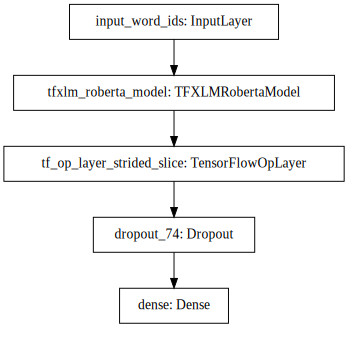

In [28]:
SVG(tf.keras.utils.model_to_dot(model, dpi=70).create(prog='dot', format='svg'))

# Learning rate schedule

In [29]:
def build_lrfn(lr_start=0.000001, lr_max=0.000002, 
               lr_min=0.0000001, lr_rampup_epochs=7, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

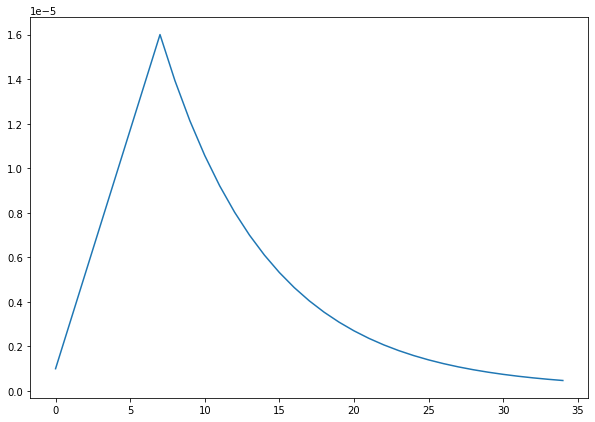

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

lrfn = build_lrfn()
plt.plot([i for i in range(35)], [lrfn(i) for i in range(35)]);

In [31]:
model_path = 'jigsawMultilingual.hdf5'
model_path1 = '/kaggle/working/jigsawMultilingual.hdf5'

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

callback_list = [checkpoint,  lr_callback]

# Training

In [33]:
%%time
N_STEPS = x_train.shape[0] // BATCH_SIZE
EPOCHS = 2
train_history = model.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks=callback_list,
    epochs=EPOCHS
)

Train for 7345 steps, validate for 63 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/2
7345/7345 [==============================] - 3711s 505ms/step - loss: 0.2306 - auc: 0.9436 - val_loss: 0.2540 - val_auc: 0.9242

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/2
7345/7345 [==============================] - 3498s 476ms/step - loss: 0.1442 - auc: 0.9782 - val_loss: 0.2394 - val_auc: 0.9283
CPU times: user 9min 35s, sys: 34.6 s, total: 10min 10s
Wall time: 2h 9s


In [34]:
if os.path.exists(model_path1):
    model.load_weights(model_path1)

we train it for 2 more epochs on the validation set, which is significantly smaller but contains a mixture of different languages.

In [35]:
%%time
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    callbacks=callback_list,
    epochs= EPOCHS
)

Train for 62 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/2
62/62 [==============================] - 126s 2s/step - loss: 0.2252 - auc: 0.9311

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-06.
Epoch 2/2
62/62 [==============================] - 142s 2s/step - loss: 0.1955 - auc: 0.9486
CPU times: user 32.2 s, sys: 973 ms, total: 33.2 s
Wall time: 4min 27s


In [36]:
if os.path.exists(model_path1):
    model.load_weights(model_path1)

In [37]:
log_dir = "/kaggle/working/log.csv"
if os.path.exists(log_dir):
    os.remove(log_dir)

# Make Submission

In [38]:
sub = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/' + 'sample_submission.csv')
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 111s 222ms/step


In [39]:
sub

,id,toxic
0,0,0.000402
1,1,0.000521
2,2,0.432036
3,3,0.000397
4,4,0.000308
...,...,...
63807,63807,0.167369
63808,63808,0.000655
63809,63809,0.011234
63810,63810,0.000721


**References**
* [Jigsaw TPU: XLM-Roberta](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta)
* [Jigsaw TPU: DistilBERT with Huggingface and Keras](https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras)
* [Jigsaw TPU: BERT with Huggingface and Keras](https://www.kaggle.com/miklgr500/jigsaw-tpu-bert-with-huggingface-and-keras)
* [8 Excellent Pretrained Models to get you Started with Natural Language Processing (NLP)](https://www.analyticsvidhya.com/blog/2019/03/pretrained-models-get-started-nlp/)
* [Introduction to PyTorch-Transformers: An Incredible Library for State-of-the-Art NLP (with Python code)](https://www.analyticsvidhya.com/blog/2019/07/pytorch-transformers-nlp-python/)

* [facebookresearch/XLM](https://github.com/facebookresearch/XLM)

* [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

* [Exploring Distributional Representations and Machine Translation for Aspect-based Cross-lingual Sentiment Classification](https://www.researchgate.net/publication/309312650_Exploring_Distributional_Representations_and_Machine_Translation_for_Aspect-based_Cross-lingual_Sentiment_Classification)
* [Fastai with 🤗 Transformers (BERT, RoBERTa, ...)](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta)
* [Jigsaw Multilingual Toxicity : EDA + Models](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models)
* [Flower Classification with TPUs - EDA and Baseline](https://www.kaggle.com/dimitreoliveira/flower-classification-with-tpus-eda-and-baseline/notebook)